In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seaborn as sns
import torch

import sys
sys.path.append('../code')

from rnaseqTools import geneSelection

from openTSNE import TSNE

%load_ext jupyter_black

In [2]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p openTSNE

Last updated: 2023-03-13 10:57:38CET

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.11.0

openTSNE: 0.6.2

matplotlib: 3.7.0
seaborn   : 0.12.2
torch     : 1.13.1
pandas    : 1.5.3
sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:42:20) 
[Clang 14.0.6 ]
numpy     : 1.23.5

Watermark: 2.3.1



### Load observed data

<mark>COMMENT</mark>: add a few words on how and where did you compute the pickle file `M1_features.pickle`, point to a specific notebook or script.

In [3]:
M1_25degree = pickle.load(open("../code/pickles/M1_features.pickle", "rb"))
ephys_features = np.array(M1_25degree["X_o"].columns)[:-4]
Xo = M1_25degree["X_o"].copy()
feature_list = range(23)

In [4]:
prop = pd.read_csv("../data/m1_patchseq_meta_data.csv", sep="\t")
prop = prop.rename(columns={"Targeted layer": "Layer"})
prop = prop[["Cell", "Layer", "Cre", "RNA type"]]
prop = prop.set_index("Cell")
prop = prop.reindex(Xo.index)
no_low_qual = np.array(list(map(str, prop["RNA type"].values))) != "nan"
prop = prop.loc[no_low_qual, :]
Xo = Xo.loc[no_low_qual, :]
celltypes = prop["RNA type"]

In [5]:
annotations = pd.read_csv("../data/cluster.annotation.csv", index_col=0)
cellTypeColors = {}
for celltype in np.unique(annotations["cluster_label"].values):
    cellTypeColors.update(
        {
            celltype: annotations.iloc[
                np.where(annotations["cluster_label"] == celltype)[0][0], :
            ]["cluster_color"]
        }
    )
colors = np.array([cellTypeColors[celltype] for celltype in celltypes])

In [6]:
model_param_names = np.array(
    [
        "C",
        r"$R_{input}$",
        r"$\tau$",
        r"$g_{Nat}$",
        r"$g_{Na}$",
        r"$g_{Kd}$",
        r"$g_{M}$",
        r"$g_{Kv31}$",
        r"$g_{L}$",
        r"$E_{leak}$",
        r"$\tau_{max}$",
        "VT",
        r"$r_{SS}$",
    ]
)
prior_min = [0.1, 20, 0.1, 0, 0, 0, 0, 0, 0, -130, 50, -90, 0.1]
prior_max = [15, 1000, 70, 250, 100, 30, 3, 250, 3, -50, 4000, -35, 3]

In [7]:
# Vip
celltype_Vip = (
    (celltypes == "Vip C1ql1")
    | (celltypes == "Vip Chat_1")
    | (celltypes == "Vip Gpc3")
    | (celltypes == "Vip Htr1f")
    | (celltypes == "Vip Mybpc1_1")
    | (celltypes == "Vip Mybpc1_2")
    | (celltypes == "Vip Mybpc1_3")
    | (celltypes == "Vip Serpinf1_1")
    | (celltypes == "Vip Serpinf1_2")
    | (celltypes == "Vip Serpinf1_3")
    | (celltypes == "Vip Sncg")
)

# Sst
celltype_Sst = (
    (celltypes == "Sst C1ql3_1")
    | (celltypes == "Sst C1ql3_2")
    | (celltypes == "Sst Calb2")
    | (celltypes == "Sst Chodl")
    | (celltypes == "Sst Crhr2_1")
    | (celltypes == "Sst Crhr2_2")
    | (celltypes == "Sst Etv1")
    | (celltypes == "Sst Hpse")
    | (celltypes == "Sst Htr1a")
    | (celltypes == "Sst Myh8_1")
    | (celltypes == "Sst Myh8_2")
    | (celltypes == "Sst Myh8_3")
    | (celltypes == "Sst Penk")
    | (celltypes == "Sst Pvalb Calb2")
    | (celltypes == "Sst Pvalb Etv1")
    | (celltypes == "Sst Tac2")
    | (celltypes == "Sst Th_1")
    | (celltypes == "Sst Th_3")
)

# Lamp5
celltype_Lamp5 = (
    (celltypes == "Lamp5 Egln3_1")
    | (celltypes == "Lamp5 Egln3_2")
    | (celltypes == "Lamp5 Lhx6")
    | (celltypes == "Lamp5 Pax6")
    | (celltypes == "Lamp5 Pdlim5_1")
    | (celltypes == "Lamp5 Pdlim5_2")
    | (celltypes == "Lamp5 Slc35d3")
)

# Pvalb
celltype_Pvalb = (
    (celltypes == "Pvalb Calb1_1")
    | (celltypes == "Pvalb Calb1_2")
    | (celltypes == "Pvalb Egfem1")
    | (celltypes == "Pvalb Gabrg1")
    | (celltypes == "Pvalb Gpr149")
    | (celltypes == "Pvalb Il1rapl2")
    | (celltypes == "Pvalb Kank4")
    | (celltypes == "Pvalb Reln")
    | (celltypes == "Pvalb Vipr2_2")
)

# Pyramidal
celltype_Pyr = (
    (celltypes == "L2/3 IT_3")
    | (celltypes == "L4/5 IT_1")
    | (celltypes == "L4/5 IT_2")
    | (celltypes == "L5 ET_1")
    | (celltypes == "L5 ET_2")
    | (celltypes == "L5 ET_3")
    | (celltypes == "L5 ET_4")
    | (celltypes == "L5 IT_1")
    | (celltypes == "L5 IT_2")
    | (celltypes == "L5 IT_3")
    | (celltypes == "L5 IT_4")
    | (celltypes == "L5/6 NP CT")
    | (celltypes == "L5/6 NP_1")
    | (celltypes == "L5/6 NP_2")
    | (celltypes == "L6 CT Cpa6")
    | (celltypes == "L6 CT Grp")
    | (celltypes == "L6 CT Pou3f2")
    | (celltypes == "L6 IT_1")
    | (celltypes == "L6 IT_2")
    | (celltypes == "L6b Col6a1")
    | (celltypes == "L6b Kcnip1")
    | (celltypes == "L6b Ror1")
    | (celltypes == "L6b Shisa6_1")
    | (celltypes == "L6b Shisa6_2")
)
# Sncg
celltype_Sncg = (
    (celltypes == "Sncg Calb1_2")
    | (celltypes == "Sncg Npy2r")
    | (celltypes == "Sncg Calb1_1")
    | (celltypes == "Sncg Col14a1")
)

### Figure 3

t-SNE overlayed with fitted model parameters, fitted electrophysiology, true electrophysiology and marker genes

<mark>COMMENT</mark>: same as last comment, add a few words on how and where did you compute the pickle files `training_schedule_x.pickle`, point to a specific notebook or script.

In [8]:
with open("../code/save_posteriors/training_schedule_0.pickle", "rb") as f:
    npe_posterior = pickle.load(f)
with open("../code/save_posteriors/training_schedule_2d.pickle", "rb") as f:
    npep_posterior = pickle.load(f)

Let us get the gene expression levels for the same cells.

In [9]:
data_exons = pd.read_csv(
    "../data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
data_exons = data_exons.T.reindex(Xo.index).T
original_gene_names = np.array(data_exons.index)
exonCounts = data_exons.values.transpose()
gene_names = original_gene_names

Select 1000 most variable genes.

Chosen offset: 7.53


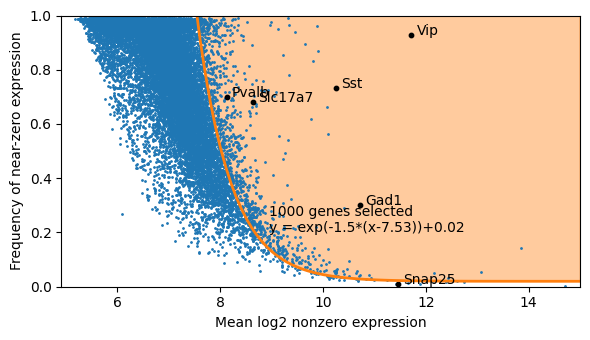

In [10]:
amount_of_genes = 1000
markerGenes = ["Snap25", "Gad1", "Slc17a7", "Pvalb", "Sst", "Vip"]
selectedGenes = geneSelection(
    exonCounts, n=amount_of_genes, threshold=30, markers=markerGenes, genes=gene_names
)
exonCounts = exonCounts[:, selectedGenes]
gene_names = gene_names[selectedGenes]

Further preprocessing for genes (library size normalization and Z-scoring).

In [11]:
genes = exonCounts.copy()
genes = (
    genes
    / np.sum(genes, axis=1, keepdims=True)
    * np.median(np.sum(genes, axis=1, keepdims=True))
)
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype("float64")

In [12]:
### uncomment to recompute

# tsne = TSNE(
#     perplexity=30,
#     metric="euclidean",
#     n_jobs=8,
#     random_state=42,
#     verbose=True,
# )

Depending on your machine, you might get a slightly different embeddings. To produce the exact same embedding run the code in the 2nd block below.

In [13]:
# Z = tsne.fit(G)

# # save embedding coordinates
# np.savez('./embedding_coordinates/tsne.npz',
#      coord=Z,
#     )

In [14]:
# load embedding coordinates
Z = np.load("./embedding_coordinates/tsne.npz")["coord"]

In [15]:
fav_tr_schedule = "2d"

##### Fetch highest posterior samples

In [16]:
with open(
    "../code/save_model_parameters/training_schedule_{}.pickle".format(fav_tr_schedule),
    "rb",
) as f:
    THETA = pickle.load(f)
highest_posterior_samples = np.concatenate(
    [
        THETA["highest posterior samples"][cell]
        if cell in THETA["highest posterior samples"]
        else np.ones((13,)) * np.nan
        for cell in Xo.index
    ]
).reshape((Xo.shape[0], len(model_param_names)))

##### Fetch random samples with evaluations from the posterior built with our favourite training schedule from `report_performances.ipynb`

In [17]:
import os
from zipfile import ZipFile

if not os.path.exists(
    "../code/save_model_parameters/favourite_training_schedule.pickle"
):
    archive = ZipFile(
        "../code/save_model_parameters/favourite_training_schedule.zip", "r"
    )
    archive.extractall(path="../code/save_model_parameters/")
with open(
    "../code/save_model_parameters/favourite_training_schedule.pickle", "rb"
) as f:
    fav_training_schedule = pickle.load(f)
samples = np.concatenate(
    [fav_training_schedule["samples"][cell] for cell in Xo.index]
).reshape((Xo.shape[0], 1000, len(model_param_names)))
samples = torch.as_tensor(samples, dtype=torch.float32)

The following result should be pretty high in comparison to next block's values

In [18]:
npep_posterior.log_prob(
    highest_posterior_samples[0, :], x=Xo.iloc[0, :].values[feature_list]
)

tensor([-29.3082])

In [19]:
npep_posterior.log_prob(samples[0, :, :], x=Xo.iloc[0, :].values[feature_list])[:10]

tensor([-37.8600, -33.9169, -32.9100, -37.8579, -34.8699, -34.7612, -33.9959,
        -32.5290, -36.2000, -36.5977])

You can run it once and then simply load next block any other time

In [20]:
### uncomment to recompute

# uncertainty=np.zeros((Xo.shape[0]))
# for i in range(Xo.shape[0]):
#     if i%100==0:
#         print(i, end='')
#     print('.', end='')
#     uncertainty[i]=torch.mean(-npep_posterior.log_prob(samples[i,:,:],x=Xo.iloc[i,:].values[feature_list])).item()
# np.savez('../code/save_uncertainty/npep_entropy.npz',
#      entropy=uncertainty
#         )

In [21]:
uncertainty = np.load("../code/save_uncertainty/npep_entropy.npz")["entropy"]

<mark>COMMENT</mark>: same here `highest_posterior_samples_summ_stats_{}.npz`

In [22]:
MAP_stats = np.load(
    "../code/save_sims/highest_posterior_samples_summ_stats_{}.npz".format(
        fav_tr_schedule
    )
)["stats"]
MAP_stats = MAP_stats

In [23]:
def create_figure_3(fig):
    if fig is None:
        fig = plt.figure(figsize=(14, 10))
    else:
        fig = fig

    width, height = 0.14, 0.12
    w_scale, h_scale = width * 1.2, height * 1.2
    ax_latent = plt.axes([0, 0.6, (w_scale - 0.02) * 2, h_scale * 2])
    axes_marker_genes = np.array(
        [
            [plt.axes([x, y, width, height]) for x in [0.167 * 2, 0.167 * 3]]
            for y in [0.6 + h_scale, 0.6]
        ]
    )
    ax_HH_uncertainty = plt.axes([w_scale * 4, 0.6, w_scale * 2, h_scale * 2])
    axes_params = np.array(
        [
            plt.axes([x, 0.4, width, height])
            for x in [0, w_scale, w_scale * 2, w_scale * 3, w_scale * 4, w_scale * 5]
        ]
    )
    axes_fitted_ephys = np.array(
        [
            plt.axes([x, 0.2, width, height])
            for x in [0, w_scale, w_scale * 2, w_scale * 3, w_scale * 4, w_scale * 5]
        ]
    )
    axes_true_ephys = np.array(
        [
            plt.axes([x, 0, width, height])
            for x in [0, w_scale, w_scale * 2, w_scale * 3, w_scale * 4, w_scale * 5]
        ]
    )

    return (
        ax_latent,
        axes_marker_genes,
        ax_HH_uncertainty,
        axes_params,
        axes_fitted_ephys,
        axes_true_ephys,
    )

In [24]:
def latent_space_overlays(
    Z,
    X,
    X_column_index,
    geneNames,
    alpha=1,
    triangle_max_len=50,
    fontsize=14,
    axis=None,
):
    """
    Parameters
    ----------
    Z: latent space coordinates (2D numpy array)
    X: normalized overlaying data (2D numpy array)
    X_column_index: column index in X, correspoding to certain feature
    names: list of feature names (X_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    triangle_max_len: # triangles with too long edges (poorly constrained by data) (default=50)
    fontsize: fontsize of title (default: 13)
    axis: axis to plot one (default: None)

    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    """

    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

    # produces triangles from latent coordinates
    triang = tri.Triangulation(Z[:, 0], Z[:, 1])

    # extract coordinates of each triangle
    x1 = Z[:, 0][triang.triangles][:, 0]
    x2 = Z[:, 0][triang.triangles][:, 1]
    x3 = Z[:, 0][triang.triangles][:, 2]
    y1 = Z[:, 1][triang.triangles][:, 0]
    y2 = Z[:, 1][triang.triangles][:, 1]
    y3 = Z[:, 1][triang.triangles][:, 2]

    # calculate edges
    edges = np.concatenate(
        (
            np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)[:, np.newaxis],
        ),
        axis=1,
    )

    # triangles with an edge longer than the 50th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(
        np.max(edges, axis=1)
        > np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-triangle_max_len]
    )
    ax.tricontourf(
        triang,
        X[:, X_column_index],
        cmap="inferno",
        levels=np.linspace(-2, 2, 5),
        extend="both",
    )
    ax.set_xlim([np.min(Z[:, 0]), np.max(Z[:, 0])])
    ax.set_ylim([np.min(Z[:, 1]), np.max(Z[:, 1])])
    ax.set_title(geneNames[X_column_index], fontsize=fontsize, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    return ax

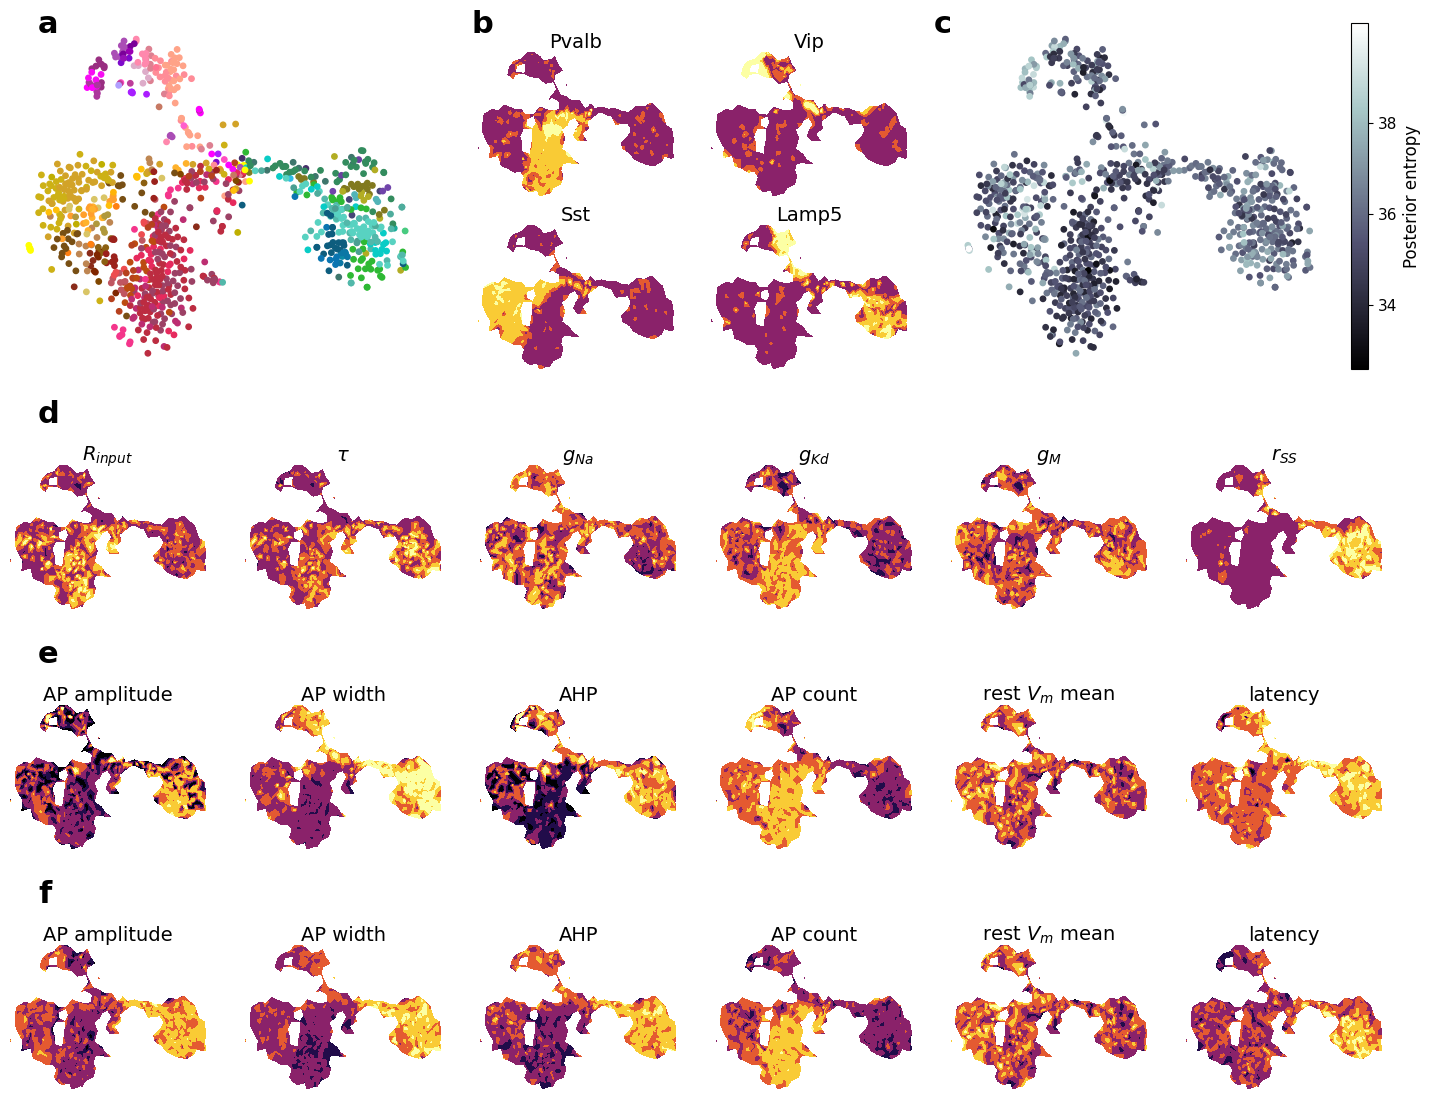

In [25]:
fig = plt.figure(figsize=(14, 12))
(
    ax_latent,
    axes_marker_genes,
    ax_HH_uncertainty,
    axes_params,
    axes_fitted_ephys,
    axes_true_ephys,
) = create_figure_3(fig)

# t-SNE latent
ax_latent.scatter(Z[:, 0], Z[:, 1], s=15, c=colors)
ax_latent.set_xticks([])
ax_latent.set_yticks([])
sns.despine(ax=ax_latent, left=True, bottom=True)

# uncertainty of fitted model parameters
scatter = ax_HH_uncertainty.scatter(Z[:, 0], Z[:, 1], s=15, c=uncertainty, cmap="bone")
cbar = plt.colorbar(
    scatter, ax=ax_HH_uncertainty, ticks=[32, 34, 36, 38]
)  # , anchor=(,.5))
cbar.ax.tick_params(labelsize=11)
cbar.set_label("Posterior entropy", fontsize=12)
ax_HH_uncertainty.set_xticks([])
ax_HH_uncertainty.set_yticks([])
sns.despine(ax=ax_HH_uncertainty, left=True, bottom=True)

# marker genes
marker_gene_ids = [
    np.where(gene_names == "Pvalb")[0][0],
    np.where(gene_names == "Vip")[0][0],
    np.where(gene_names == "Sst")[0][0],
    np.where(gene_names == "Lamp5")[0][0],
]
for i, ax in enumerate(axes_marker_genes.reshape(-1)):
    latent_space_overlays(
        Z, G, marker_gene_ids[i], gene_names, triangle_max_len=150, axis=ax
    )
    sns.despine(ax=ax, bottom=True, left=True)

# model params
model_param_ids_to_show = [1, 2, 4, 5, 6, -1]
for i, ax in enumerate(axes_params):
    latent_space_overlays(
        Z,
        (highest_posterior_samples - highest_posterior_samples.mean(axis=0))
        / highest_posterior_samples.std(axis=0),
        model_param_ids_to_show[i],
        model_param_names,
        triangle_max_len=150,
        axis=ax,
    )
    sns.despine(ax=ax, bottom=True, left=True)

ephys_feature_ids_to_show = [1, 2, 3, 8, 19, 18]
for i, ax in enumerate(axes_fitted_ephys.reshape(-1)):
    latent_space_overlays(
        Z[~np.isnan(MAP_stats.mean(axis=1)), :],
        (MAP_stats[~np.isnan(MAP_stats.mean(axis=1)), :] - Xo.values.mean(axis=0)[:-4])
        / Xo.values.std(axis=0)[:-4],
        ephys_feature_ids_to_show[i],
        ephys_features,
        triangle_max_len=150,
        axis=ax,
    )
    sns.despine(ax=ax, bottom=True, left=True)

for i, ax in enumerate(axes_true_ephys.reshape(-1)):
    latent_space_overlays(
        Z,
        (Xo.values[:, :-4] - Xo.values.mean(axis=0)[:-4]) / Xo.values.std(axis=0)[:-4],
        ephys_feature_ids_to_show[i],
        ephys_features,
        triangle_max_len=150,
        axis=ax,
    )
    sns.despine(ax=ax, bottom=True, left=True)

shift = 0.02
fig.text(0 + shift, 0.88, "a", fontsize=22, fontweight="bold")
# fig.text(.11, .91, 'Latent', fontsize=19)
fig.text(0.33, 0.88, "b", fontsize=22, fontweight="bold")
# fig.text(.43, .91, 'Marker genes', fontsize=19)
fig.text(0.66, 0.88, "c", fontsize=22, fontweight="bold")
# fig.text(.73, .91, 'Fit uncertainty', fontsize=19)
fig.text(0 + shift, 0.555, "d", fontsize=22, fontweight="bold")
# fig.text(.36, .555, 'Model parameters', fontsize=19)
fig.text(0 + shift, 0.355, "e", fontsize=22, fontweight="bold")
# fig.text(.33, .355, 'Model electrophysiology', fontsize=19)
fig.text(0 + shift, 0.155, "f", fontsize=22, fontweight="bold")
# fig.text(.31, .155, 'Experimental electrophysiology', fontsize=19)

plt.savefig("figure_3.png", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_3.pdf", bbox_inches="tight", pad_inches=0)